In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import datasets, layers, models, mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image

# Configurações de semente para reprodutibilidade
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Ativa mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

print("GPU Disponível:", tf.config.list_physical_devices('GPU'))

GPU Disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(8192)

In [7]:
# Aplica transformações de aumento de dados
train_dataset = train_dataset.map(
    lambda image, label: (
        tf.image.random_flip_left_right(image),
        tf.cast(label, tf.int32)
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.map(
    lambda image, label: (
        tf.image.random_brightness(image, 0.05),
        label
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.map(
    lambda image, label: (
        tf.image.random_contrast(image, 0.95, 1.05),
        label
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [8]:
# Aplica CutMix simplificado
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(
    lambda images, labels: (
        tf.cond(
            tf.random.uniform(()) > 0.1,
            lambda: (images, labels),
            lambda: (tf.identity(images), tf.identity(labels))
        )
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.RandomRotation(0.01, fill_mode='nearest'),
    layers.RandomZoom(0.03, fill_mode='nearest'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Dropout(0.35),
    layers.Dense(256, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('gelu'),
    layers.Dropout(0.35),
    layers.Dense(10, dtype='float32')
])

opt = tf.keras.optimizers.AdamW(learning_rate=0.0015, weight_decay=1e-4)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')]
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

In [10]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.3773 - loss: 1.7447 - top5_acc: 0.8580 - val_accuracy: 0.6195 - val_loss: 1.0885 - val_top5_acc: 0.9640 - learning_rate: 0.0015
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6325 - loss: 1.0319 - top5_acc: 0.9651 - val_accuracy: 0.6654 - val_loss: 1.0060 - val_top5_acc: 0.9694 - learning_rate: 0.0015
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7093 - loss: 0.8237 - top5_acc: 0.9787 - val_accuracy: 0.7480 - val_loss: 0.7366 - val_top5_acc: 0.9821 - learning_rate: 0.0015
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.7509 - loss: 0.7188 - top5_acc: 0.9846 - val_accuracy: 0.7715 - val_loss: 0.6572 - val_top5_acc: 0.9855 - learning_rate: 0.0015
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7779 - loss: 0.6400 - top5_acc: 0.9872 - val_accuracy: 0.7614 - val_loss: 0.7100 - val_top5_acc: 0.9883 - learning_rate: 0.0015
Epoch 6/100
391

313/313 - 1s - 4ms/step - accuracy: 0.9234 - loss: 0.3494 - top5_acc: 0.9978
Acurácia no teste: 0.9234
Acurácia top-5 no teste: 0.9978
Média de acurácia na última época: 0.9557


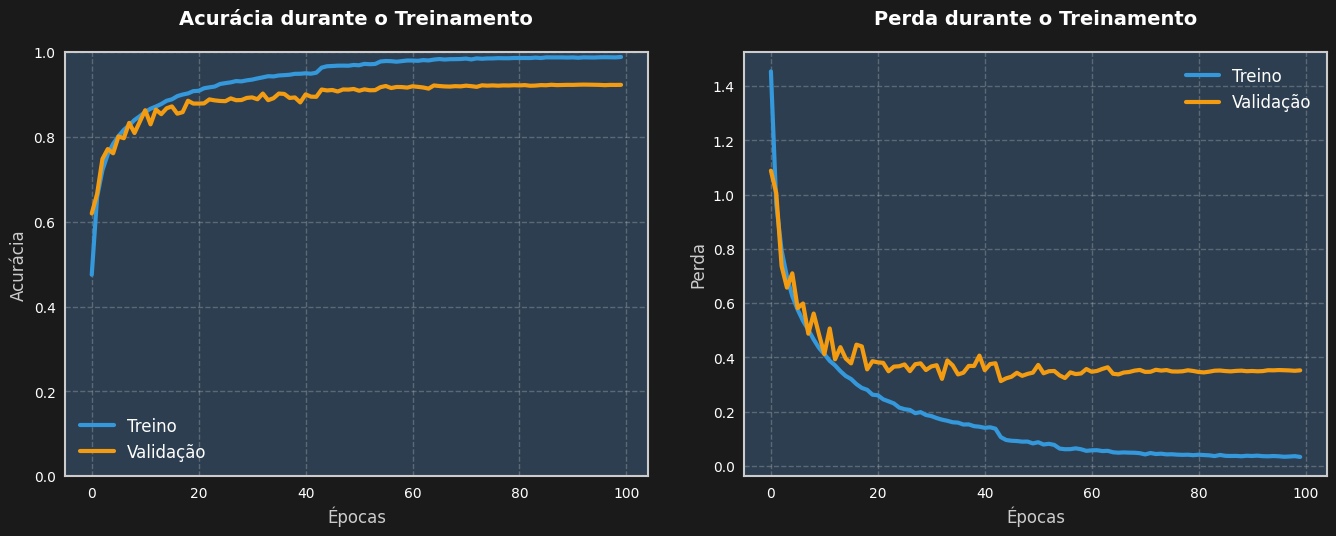

In [29]:
# Avalia o modelo
test_loss, test_acc, test_top5_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Acurácia no teste: {test_acc:.4f}")
print(f"Acurácia top-5 no teste: {test_top5_acc:.4f}")

# Calcula a média (accuracy + val_accuracy) / 2 para a última época
mean_acc_last_epoch = (history.history['accuracy'][-1] + history.history['val_accuracy'][-1]) / 2
print(f"Média de acurácia na última época: {mean_acc_last_epoch:.4f}")

# Configurações de estilo para tema escuro
plt.style.use('dark_background')
plt.rcParams['axes.edgecolor'] = '0.8'
plt.rcParams['axes.linewidth'] = 1.5

# Cores personalizadas
azul = '#3498db'    # Azul vibrante
laranja = '#f39c12' # Laranja vibrante
fundo = '#1a1a1a'   # Cor de fundo escura

# Visualiza os resultados
fig = plt.figure(figsize=(14, 6), facecolor=fundo)

# Subplot para Acurácia
ax1 = plt.subplot(1, 2, 1, facecolor='#2c3e50')
plt.plot(history.history['accuracy'], linewidth=3, label='Treino', color=azul)
plt.plot(history.history['val_accuracy'], linewidth=3, label='Validação', color=laranja)
plt.title('Acurácia durante o Treinamento', fontsize=14, pad=20, color='white', weight='bold')
plt.xlabel('Épocas', fontsize=12, color='0.8')
plt.ylabel('Acurácia', fontsize=12, color='0.8')
plt.legend(fontsize=12, framealpha=0.2, facecolor='#2c3e50', edgecolor='0.8')
plt.grid(True, linestyle='--', alpha=0.3, color='0.8')
plt.ylim(0, 1)

# Subplot para Perda
ax2 = plt.subplot(1, 2, 2, facecolor='#2c3e50')
plt.plot(history.history['loss'], linewidth=3, label='Treino', color=azul)
plt.plot(history.history['val_loss'], linewidth=3, label='Validação', color=laranja)
plt.title('Perda durante o Treinamento', fontsize=14, pad=20, color='white', weight='bold')
plt.xlabel('Épocas', fontsize=12, color='0.8')
plt.ylabel('Perda', fontsize=12, color='0.8')
plt.legend(fontsize=12, framealpha=0.2, facecolor='#2c3e50', edgecolor='0.8')
plt.grid(True, linestyle='--', alpha=0.3, color='0.8')

# Ajustes finais
plt.tight_layout(pad=3.0)
plt.savefig('training_metrics_dark_clean.png', dpi=300, bbox_inches='tight', facecolor=fundo)
plt.show()

In [15]:
model.save('cifar10_model.keras')

# Uso prático do Modelo

In [16]:
model = load_model('cifar10_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 40 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
# Carrega e preprocessa uma imagem nova (32x32, RGB)
image_path = 'gato.jpg'
img = Image.open(image_path).resize((32, 32))
img_array = np.array(img).astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Adiciona batch dimension

# Faz previsão
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
classes = ['avião', 'carro', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']
print(f"Classe prevista: {classes[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Classe prevista: gato


In [32]:
probabilities = tf.nn.softmax(predictions[0]).numpy()
for i, prob in enumerate(probabilities):
    print(f"{classes[i]}: {prob:.4f}")

avião: 0.0000
carro: 0.0000
pássaro: 0.0000
gato: 1.0000
cervo: 0.0000
cachorro: 0.0000
sapo: 0.0000
cavalo: 0.0000
navio: 0.0000
caminhão: 0.0000
